In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [2]:
""" Holdout validation """

def holdout(X, y, typ):
    
    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Fit the model
    model = typ
    clf = model.fit(X_train, y_train)
    
    # confusion matrix, accuracy, recall, precision
    acc, confusion_mat, recall, precision = [], [], [], []
    for p in range(3):
        TP, FP, FN, TN = 0, 0, 0, 0
        pred = clf.predict(X_test)
        positive = label_list[p]
        for i in range(len(X_test)):
            if pred[i] == positive and y_test[i] == positive:
                TP += 1
            elif pred[i] == positive and y_test[i] != positive:
                FP += 1
            elif pred[i] != positive and y_test[i] == positive:
                FN += 1
            elif pred[i] != positive and y_test[i] != positive:
                TN += 1
        mat = pd.DataFrame([[TP, FP], [FN, TN]])
        confusion_mat.append(mat)
        acc.append((TP+TN)/len(X_test))
        recall.append(TP/(TP+FN))
        precision.append(TP/(TP+FP))
    
    # Return relevant data for chart plotting
    return clf, confusion_mat, acc, recall, precision

In [3]:
""" K-fold """

def kfold(X, y, typ):
    
    K = 3
    kf_clfs = []
    score_sum = 0
    
    kf = KFold(n_splits=K)
    
    confusion_mat, acc, recall, precision = [], [], [], [] # list of 3 label being positive
    for p in range(3): # for each class being positive
        positive = label_list[p]
        mats, accs, recalls, precisions = [], [], [], [] # list of 3 folds
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model
            model = typ
            clf = model.fit(X_train, y_train)
            kf_clfs.append(clf)

            # confusion matrix, accuracy, recall, precision
            TP, FP, FN, TN = 0, 0, 0, 0
            pred = clf.predict(X_test)
            for i in range(len(X_test)):
                if pred[i] == positive and y_test[i] == positive:
                    TP += 1
                elif pred[i] == positive and y_test[i] != positive:
                    FP += 1
                elif pred[i] != positive and y_test[i] == positive:
                    FN += 1
                elif pred[i] != positive and y_test[i] != positive:
                    TN += 1
            mats.append(pd.DataFrame([[TP, FP], [FN, TN]]))
            accs.append((TP+TN)/len(X_test))
            recalls.append(TP/(TP+FN))
            precisions.append(TP/(TP+FP))
    
        mat = (mats[0]+mats[1]+mats[2])/3
        confusion_mat.append(mat)
        acc.append(sum(accs) / K)
        recall.append(sum(recalls) / K)
        precision.append(sum(precisions) / K)

    # Return relevant data for chart plotting
    return kf_clfs, confusion_mat, acc, recall, precision

In [20]:
""" Data input """

name_list = ['sepal-length','sepal-width','petal-length','petal-width','class']
data = pd.read_csv('iris.data', sep=",", names=name_list)
feature_list = name_list
feature_list.remove('class')
label_list = ['Iris-setosa','Iris-versicolor','Iris-virginica']

""" Data preprocessing """

# Drop feature w/ missing value 
# nothing

# Divide data into group according to their class
data_group = data.groupby('class')

# shuffle
data = data.sample(frac=1)

In [21]:
""" Model Constructiong & Validation """

# Select data for modeling
X=data[feature_list]
y=data['class'].values

# Fit the model and print the result
holdout_clf, mat, acc, recall, precision = holdout(X,y,GaussianNB())
performance = []
for i in range(3):
    performance.append([acc[i], recall[i], precision[i]])

kf_clfs, mat2, acc2, recall2, precision2 = kfold(X,y,GaussianNB())
performance2 = []
for i in range(3):
    performance2.append([acc2[i], recall2[i], precision2[i]])
    

# Plot table

con_mat_table = []
for i in range(3):
    con_mat_table.append(pd.DataFrame([[mat[i][0][0], mat[i][1][0], mat2[i][0][0], mat2[i][1][0]],[mat[i][0][1], mat[i][1][1], mat2[i][0][1], mat2[i][1][1]]],
                      index=pd.Index([label_list[i]+' (Positive)', 'Else (negative)'], name='Predicted:'),
                      columns=pd.MultiIndex.from_product([['Holdout', 'K-fold'],[label_list[i], 'Else']], names=['Validation:', 'Actual:'])))

performance_table = pd.DataFrame([performance[0]+performance2[0], performance[1]+performance2[1], performance[2]+performance2[2]],
                  index=pd.Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], name='Positive:'),
                  columns=pd.MultiIndex.from_product([['Holdout', 'K-fold'],['Accuracy', 'Recall', 'Precision']], names=['Validation:', 'Performance:']))
mean = performance_table.mean(axis=0)
performance_table.loc['mean'] = mean

In [22]:
con_mat_table[2]

Validation:                      Holdout              K-fold           
Actual:                   Iris-virginica Else Iris-virginica       Else
Predicted:                                                             
Iris-virginica (Positive)             15    1      15.333333   1.666667
Else (negative)                        1   28       1.333333  31.666667

In [23]:
performance_table

Validation:       Holdout                       K-fold                    
Performance:     Accuracy    Recall Precision Accuracy    Recall Precision
Positive:                                                                 
Iris-setosa      1.000000  1.000000  1.000000     1.00  1.000000  1.000000
Iris-versicolor  0.955556  0.933333  0.933333     0.94  0.901260  0.920192
Iris-virginica   0.955556  0.937500  0.937500     0.94  0.920343  0.904003
mean             0.970370  0.956944  0.956944     0.96  0.940534  0.941399

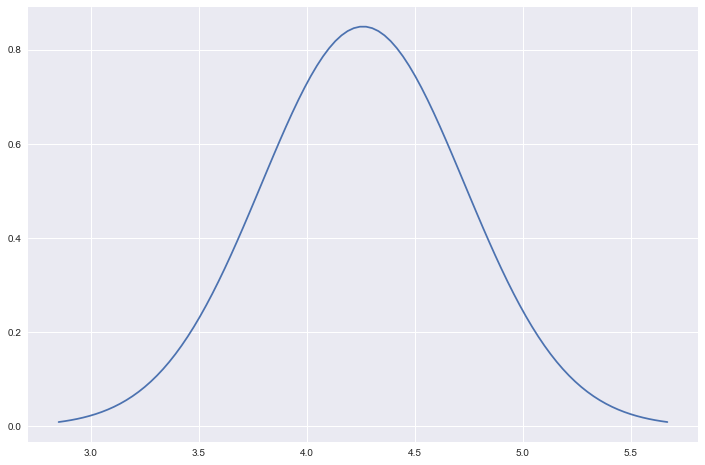

In [25]:
""" Question """

# Q1
Avg = 4.26 # Sample mean
SD = 0.469911 # Sample standard deviation

# Q2
# Use normal distribution
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
x = np.linspace(-10, 30, 10000)
mu = Avg
sigma = SD

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

------------------------- Feature = sepal-length -------------------------


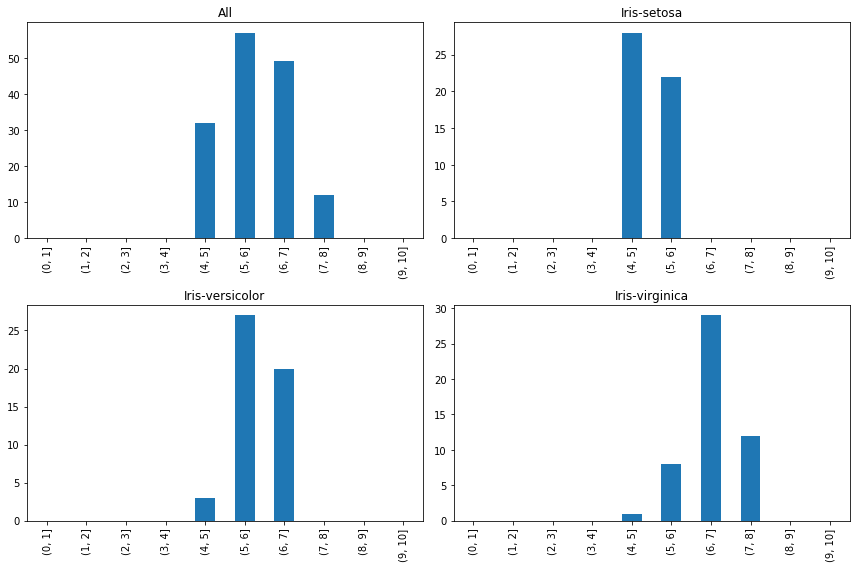

                      Avg        SD
All              5.843333  0.828066
Iris-setosa      5.006000  0.352490
Iris-versicolor  5.936000  0.516171
Iris-virginica   6.588000  0.635880

------------------------- Feature = sepal-width -------------------------


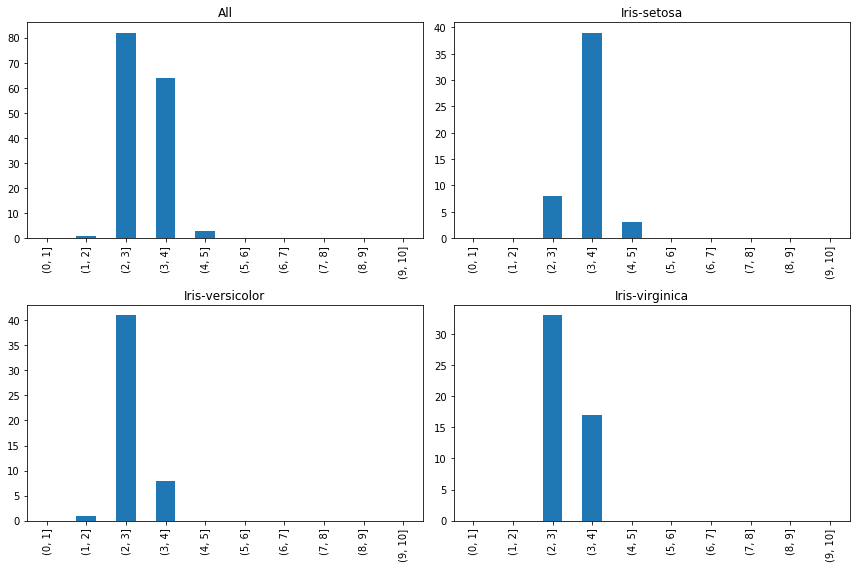

                   Avg        SD
All              3.054  0.433594
Iris-setosa      3.418  0.381024
Iris-versicolor  2.770  0.313798
Iris-virginica   2.974  0.322497

------------------------- Feature = petal-length -------------------------


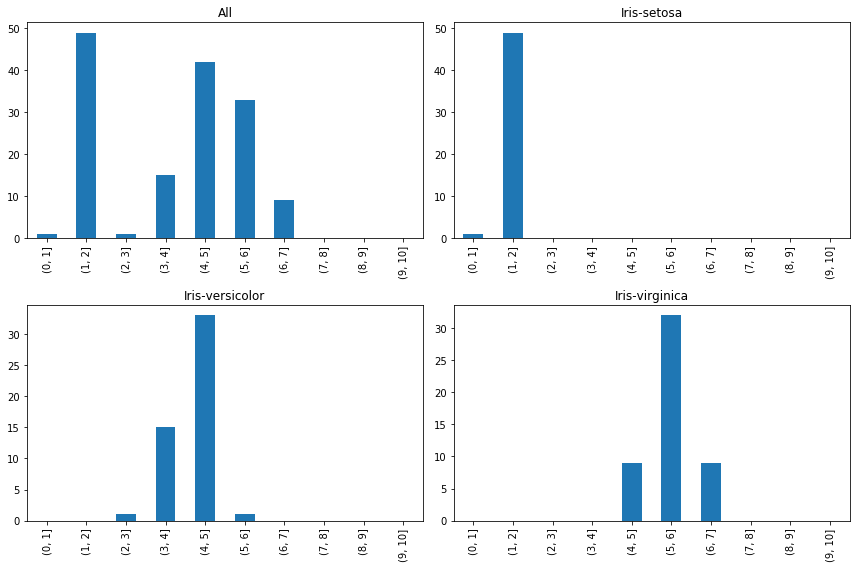

                      Avg        SD
All              3.758667  1.764420
Iris-setosa      1.464000  0.173511
Iris-versicolor  4.260000  0.469911
Iris-virginica   5.552000  0.551895

------------------------- Feature = petal-width -------------------------


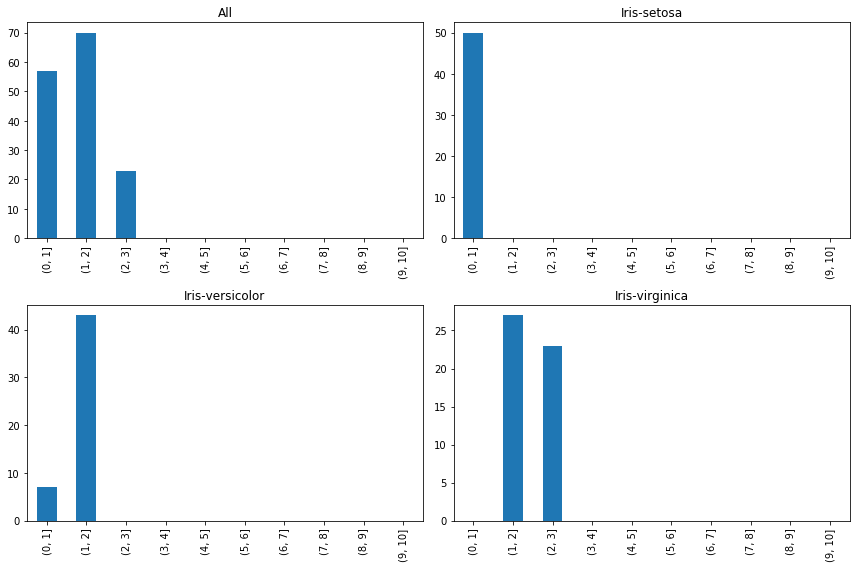

                      Avg        SD
All              1.198667  0.763161
Iris-setosa      0.244000  0.107210
Iris-versicolor  1.326000  0.197753
Iris-virginica   2.026000  0.274650



In [9]:
""" Data visualization (Iris) """

for i, feature in enumerate(feature_list):
    
    class_list = ['All','Iris-setosa','Iris-versicolor','Iris-virginica']
    data_list = [data[feature], data_group.get_group('Iris-setosa')[feature], data_group.get_group('Iris-versicolor')[feature], data_group.get_group('Iris-virginica')[feature]]
    
    print("------------------------- Feature = " + feature + " -------------------------")
    plt.figure()
    for i in range(4):
        cats = pd.cut(data_list[i], [0,1,2,3,4,5,6,7,8,9,10])
        plt.subplot(2,2,i+1)
        plt.title(class_list[i])
        cats.value_counts().sort_index().plot.bar()
    plt.tight_layout()
    plt.show()
    
    Array = []
    Array.append([data_list[0].mean(), data_list[0].std()])
    Array.append([data_list[1].mean(), data_list[1].std()])
    Array.append([data_list[2].mean(), data_list[2].std()])
    Array.append([data_list[3].mean(), data_list[3].std()])
    df = pd.DataFrame(Array, columns = ['Avg','SD'], index = ['All', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', ], dtype = float)
    print(df)
    print()